In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

from sklearn import metrics
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

In [8]:
# Load csv file
df = pd.read_csv('distances720p.csv')

In [9]:
# check rows and columns of the dataset
df.shape

(5033, 4)

In [10]:
# Check unique values of target varaible
df['class'].value_counts()

class
looks good         1810
sit up straight    1697
straighten head    1526
Name: count, dtype: int64

In [11]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 3 numerical features : ['dist_left_ear_shoulder', 'dist_right_ear_shoulder', 'dist_shoulder_nose']

We have 1 categorical features : ['class']


Positive: 0, Negative: 0


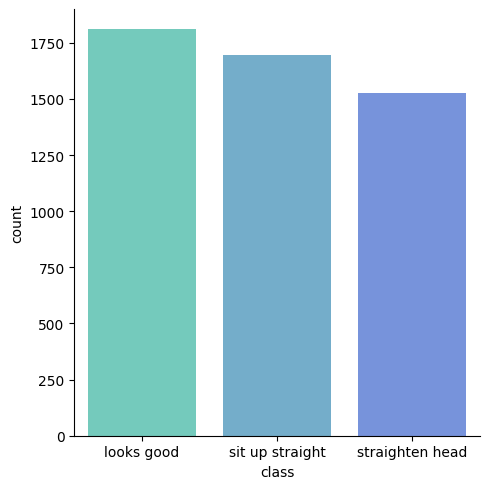

In [12]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=.6)
plt.show()

In [42]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, ROC-AUC Score
    '''
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted, average='weighted')  # Use weighted averaging for F1-score
    precision = precision_score(true, predicted, average='weighted')  # Use weighted averaging for precision
    recall = recall_score(true, predicted, average='weighted')  # Use weighted averaging for recall
    return acc, f1, precision, recall

In [86]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list)))
        
    return report

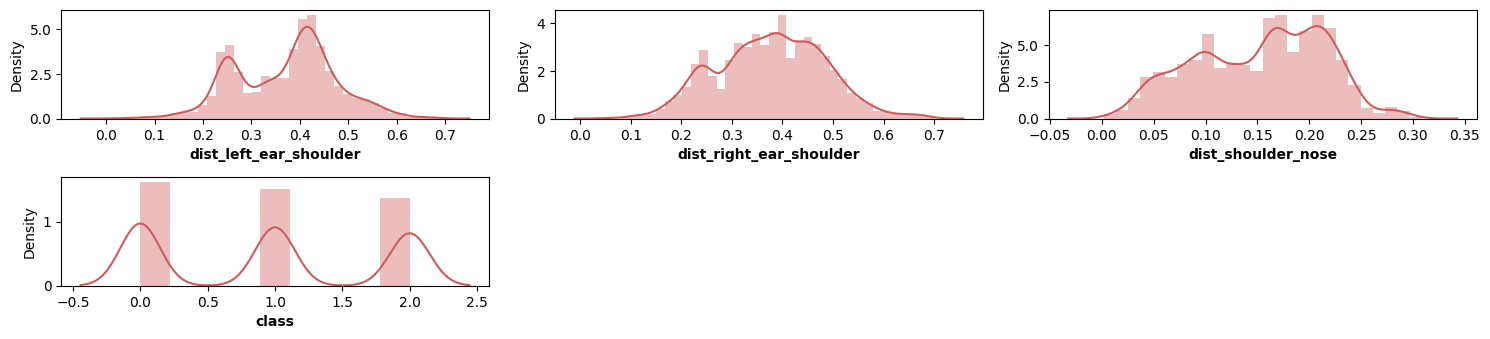

In [87]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [88]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

In [89]:
# Splitting X and y for all Experiments
X= df.drop('class', axis=1)
y = df['class']

In [90]:
X.head()

,dist_left_ear_shoulder,dist_right_ear_shoulder,dist_shoulder_nose
0,0.406014,0.366057,0.158349
1,0.396291,0.378735,0.184054
2,0.388994,0.390084,0.181476
3,0.412523,0.375311,0.161365
4,0.389295,0.371843,0.175464


In [91]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [92]:
# Fit with robust scaler for KNN best K-selection experminet
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

In [93]:
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.4033)
n_neighbors= 3 || accuracy (0.4033)
n_neighbors= 5 || accuracy (0.4033)
n_neighbors= 7 || accuracy (0.4033)
n_neighbors= 9 || accuracy (0.4033)


In [94]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [95]:
X_knn =knn_pipeline.fit_transform(X)

In [96]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

In [97]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [98]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9106
- F1 score: 0.9100
- Precision: 0.9103
- Recall: 0.9106


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8765
- F1 score: 0.8764
- Precision: 0.8764
- Recall: 0.8765


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8922
- F1 score: 0.8916
- Precision: 0.8935
- Recall: 0.8922
----------------------------------
Model performance for Test set
- Accuracy: 0.8504
- F1 score: 0.8492
- Precision: 0.8514
- Recall: 0.8504


Logistic Regression
Model performance for Training set
- Accuracy: 0.6029
- F1 score: 0.5905
- Precision: 0.5955
- Recall: 0.6029
----------------------------------
Model performance for Test set

In [99]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [100]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [101]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

In [102]:
# Training the models
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9096
- F1 score: 0.9091
- Precision: 0.9092
- Recall: 0.9096


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8755
- F1 score: 0.8753
- Precision: 0.8753
- Recall: 0.8755


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8922
- F1 score: 0.8916
- Precision: 0.8935
- Recall: 0.8922
----------------------------------
Model performance for Test set
- Accuracy: 0.8504
- F1 score: 0.8492
- Precision: 0.8514
- Recall: 0.8504


Logistic Regression
Model performance for Training set
- Accuracy: 0.6029
- F1 score: 0.5905
- Precision: 0.5955
- Recall: 0.6029
----------------------------------
Model performance for Test set

In [110]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [111]:
X_const =constant_pipeline.fit_transform(X)

In [112]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [113]:
# training the models
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9066
- F1 score: 0.9060
- Precision: 0.9063
- Recall: 0.9066


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8735
- F1 score: 0.8733
- Precision: 0.8732
- Recall: 0.8735


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8922
- F1 score: 0.8916
- Precision: 0.8935
- Recall: 0.8922
----------------------------------
Model performance for Test set
- Accuracy: 0.8504
- F1 score: 0.8492
- Precision: 0.8514
- Recall: 0.8504


Logistic Regression
Model performance for Training set
- Accuracy: 0.6029
- F1 score: 0.5905
- Precision: 0.5955
- Recall: 0.6029
----------------------------------
Model performance for Test set